In [1]:
import rasterio
import numpy as np
import os

In [2]:
filename = "20181231_030924_0f1a_3B_AnalyticMS.tif"

In [3]:
os.getcwd()

'C:\\Users\\maddi'

In [4]:
os.chdir(r"C:\Users\maddi\Desktop")
os.getcwd()

'C:\\Users\\maddi\\Desktop'

In [5]:
with rasterio.open(filename) as src:
    band_red = src.read(3)

with rasterio.open(filename) as src:
    band_nir = src.read(4)

In [6]:
from xml.dom import minidom

xmldoc = minidom.parse("20181217_025143_101e_3B_AnalyticMS_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply the Digital Number (DN) values in each band by the TOA reflectance coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

In [7]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI. This is the equation at the top of this guide expressed in code
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [8]:
np.nanmin(ndvi), np.nanmax(ndvi)

(-0.48877051022631746, 0.4950769257658376)

In [9]:
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [16]:
plt.imsave("testash.tif", ndvi, cmap=plt.cm.RdYlGn)

In [12]:
import numpy.ma as ma

In [27]:
ndvi2 = np.ma.masked_where(ndvi < 0., ndvi)

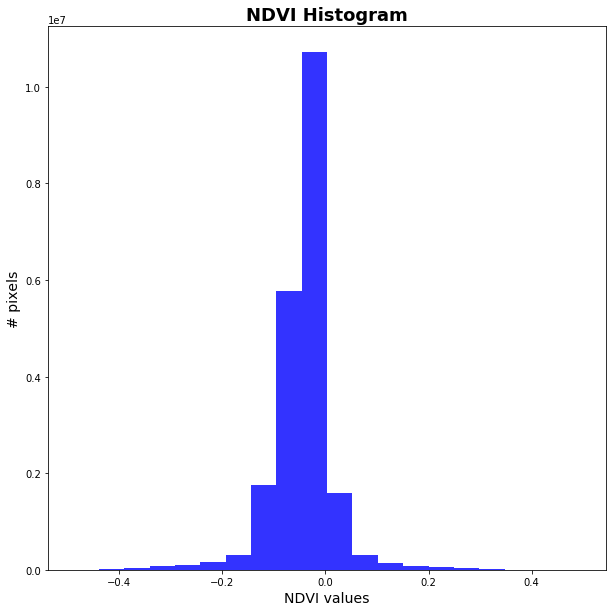

In [15]:
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='blue',alpha=0.8)

fig2.savefig("ndvi-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()